In [1]:
import sys
sys.path.append('/work/')
import re
from dCSFA_NMF import dCSFA_NMF
import umc_data_tools as umc_dt
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import torch
import random

- Only use win/lose or other binary labels.

- Compare trials to before tone time

## Loading the Data

In [2]:
DS_FEATURES = False

# Note, we are using the demo test set for the validation data in this demo. 
# Make sure you save your test sets for final analysis in real projects.
TRAINING_DATA_FILE = "ephys_data_win_lose.pkl" # "TeST_train_dict.pkl" #
VALIDATION_DATA_FILE = "ephys_data_win_lose_val.pkl" # "TeST_test_dict.pkl" # not used if train contains all data (see wher val dict is defined)

# Features used in our data construction. 
# In this example we are using power, coherence, and granger caussality.

if not DS_FEATURES:
    X_FEATURE_LIST = ["X_psd","X_coh","X_gc"]
else:
    X_FEATURE_LIST = ["X_psd_ds","X_ds"]

# These weights allow for multiplying a given feature by a constant. 
# For example, if power is significantly lower magnitude than other features, 
# we can set the weight to upscale those features. 
# There are countermeasures in the model that handle this already though, 
# so a default of 1 for every feature is usually sufficient
X_FEATURE_WEIGHTS = [1,1,1] 

# Feature for which we would like to predict. 
# In this demo, we will need to convert these values to a binary vector. 
# Your case may already be in a binary vector however.
Y_FEATURE = "y_task" 

# Feature for which you would like to make an intercept for each unique value. 
# Typically this is done per mouse.
Y_INTERCEPT_FEATURE = "y_mouse" 

# Y_SAMPLING_FEATURE can be used to ensure equal use in the model for different groups. 
# If "y_mosue" is used, then each mouse will have equal influence on the model, 
# regardless of recording length.
Y_SAMPLING_FEATURE = "y_mouse" 

# The label you wish to predict. 
# In this demo, we are predicting the Tail-Suspension (TS) condition.
Y_LABEL = "win" #"TS"


In [3]:
# Loading the training data
with open(TRAINING_DATA_FILE,"rb") as f:
    train_dict = pickle.load(f)

# show train dict
print("All data (train_dict):")
for i in train_dict.keys():
    try:
        print(i,":", train_dict[i].shape)
    except:
        print(i,":",len(train_dict[i]))
print("\n")


# # Loading the validation data
# with open(VALIDATION_DATA_FILE,"rb") as f:
#     val_dict = pickle.load(f)

# split training data into train and val data by mouse name
# Get indexes for val data
###############################
val_lst = ["1.2"] # (1.2) select which mice to include in validation data here (1.1, 1.2, 1.4)
###############################
val_idx = np.where(np.isin(train_dict['y_mouse'], val_lst))[0]
# make val dict
val_dict = train_dict.copy()
val_dict['X_lfp'] = val_dict['X_lfp'][:,val_idx,:]
val_dict['X_psd'] = val_dict['X_psd'][val_idx,:]
val_dict['X_coh'] = val_dict['X_coh'][val_idx,:]
val_dict['X_gc'] = val_dict['X_gc'][val_idx,:]
val_dict['y_mouse'] = val_dict['y_mouse'][val_idx]
val_dict['y_task'] = val_dict['y_task'][val_idx]

# save valid data for later
# Open the file in write-binary mode and save the data
with open(VALIDATION_DATA_FILE, 'wb') as file:
    pickle.dump(val_dict, file)

# show train dict
print("Valid:")
for i in val_dict.keys():
    try:
        print(i,":", val_dict[i].shape)
    except:
        print(i,":",len(val_dict[i]))
print("\n")

# make new cut train dict
# make val dict
# Make new train dict by excluding val indices
train_idx = np.setdiff1d(np.arange(len(train_dict['y_mouse'])), val_idx)
train_dict['X_lfp'] = train_dict['X_lfp'][:,train_idx,:]
train_dict['X_psd'] = train_dict['X_psd'][train_idx,:]
train_dict['X_coh'] = train_dict['X_coh'][train_idx,:]
train_dict['X_gc'] = train_dict['X_gc'][train_idx,:]
train_dict['y_mouse'] = train_dict['y_mouse'][train_idx]
train_dict['y_task'] = train_dict['y_task'][train_idx]

# show train dict
print("Train (NEW):")
for i in train_dict.keys():
    try:
        print(i,":", train_dict[i].shape)
    except:
        print(i,":",len(train_dict[i]))
print("\n")

All data (train_dict):
X_lfp : (5, 194, 9999)
X_psd : (194, 280)
X_coh : (194, 560)
X_gc : (194, 1120)
y_mouse : (194,)
y_task : (194,)
Freqs : (56,)
powFeatures : (280,)
cohFeatures : (560,)
gcFeatures : (1120,)
areas : 5


Valid:
X_lfp : (5, 58, 9999)
X_psd : (58, 280)
X_coh : (58, 560)
X_gc : (58, 1120)
y_mouse : (58,)
y_task : (58,)
Freqs : (56,)
powFeatures : (280,)
cohFeatures : (560,)
gcFeatures : (1120,)
areas : 5


Train (NEW):
X_lfp : (5, 136, 9999)
X_psd : (136, 280)
X_coh : (136, 560)
X_gc : (136, 1120)
y_mouse : (136,)
y_task : (136,)
Freqs : (56,)
powFeatures : (280,)
cohFeatures : (560,)
gcFeatures : (1120,)
areas : 5




In [4]:
# randomize labels to see effect of randomization
# Set the seed for reproducibility
random.seed(42)
# Shuffle the list
train_dict['task'] = random.shuffle(train_dict['y_task'])

In [5]:
# Create X matrices
X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(X_FEATURE_LIST,X_FEATURE_WEIGHTS)])
X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(X_FEATURE_LIST,X_FEATURE_WEIGHTS)])

# Create y vectors for prediction. 
# In this case we wish to predict for the Tail-Suspension (TS) condition and 
# convert our label vector to {1: TS, 0: other}.
y_train = (train_dict[Y_FEATURE]==Y_LABEL).reshape(-1,1)
y_val = (val_dict[Y_FEATURE]==Y_LABEL).reshape(-1,1)

# Create intercept and sampling vectors (note, these vectors are only relevant to training)
y_intercept_train = train_dict[Y_INTERCEPT_FEATURE]
y_sampling_train = OrdinalEncoder().fit_transform(train_dict[Y_SAMPLING_FEATURE].reshape(-1,1))
y_intercept_mask = OneHotEncoder().fit_transform(y_intercept_train.reshape(-1,1)).todense()

<hr>

<hr>

<hr>

Inputs:

X_psd: Power spectral density (PSD) measures of local field potentials (LFP), indicating oscillatory amplitudes across frequencies.
X_coh: Coherence measures, which quantify how two LFPs correlate across frequencies, indicating synchrony between brain regions.
X_gc: Granger causality (GC) measures, used to infer the directionality of information transfer within a circuit.
X_psd_ds: Down-sampled power spectral density data.
X_ds: General down-sampled data of brain activity measures.
Labels:

y_mouse: Individual mouse identifiers, used to track data per mouse.
y_task: Task labels indicating different experimental conditions or tasks.
y_geno: Genotype labels indicating the genetic background or modifications of the mice.
Additional Features:

Freqs: Frequencies at which the PSD, coherence, and GC measures are calculated.
powFeatures: Power features derived from the PSD data.
cohFeatures: Coherence features derived from the coherence data.
gcFeatures: Granger causality features derived from the GC data.
dsFeatures: Features derived from down-sampled data.
areas: Brain areas where the recordings were taken, such as the prefrontal cortex (PFC), nucleus accumbens (NAc), amygdala (AMY), etc.
These inputs and labels help the dCSFA-NMF model learn network structures and patterns of brain activity that encode external behavioral variables, particularly those related to social and appetitive behaviors in mice

The labels 'TS', 'OF', and 'HC' in the context of the data described in the provided papers likely represent different experimental conditions or tasks. Here's a plausible explanation for each label:

TS (Two-Chamber Social assay):

This label likely represents data collected during the two-chamber social preference assay. In this task, mice choose between spending time with another mouse (social stimulus) or with an inanimate object.
OF (Open Field test):

This label likely represents data collected during the open field test. The open field test is typically used to assess general locomotor activity levels, anxiety, and willingness to explore in rodents.
HC (Home Cage activity):

This label likely represents data collected while the mice are in their home cages. Home cage activity measurements are used to assess the baseline or natural behavior of the mice without experimental interventions.

<hr>

<hr>

## Visualizing Our Data

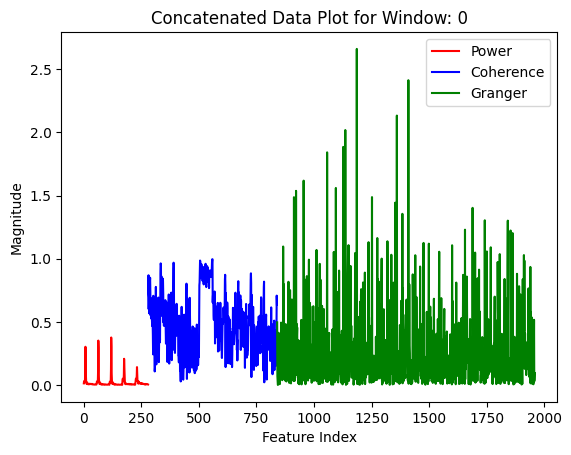

In [6]:
#I often find it helpful to look at a few individual windows

if not DS_FEATURES:
        num_power_features = len(train_dict['powFeatures'])
        num_coh_features = len(train_dict['cohFeatures'])
        num_gc_features = len(train_dict['gcFeatures'])
        window = 0
        plt.plot(range(num_power_features),train_dict['X_psd'][window,:],c='red',label='Power')
        plt.plot(range(num_power_features,num_coh_features+num_power_features),train_dict['X_coh'][window,:],c='blue',label='Coherence')
        plt.plot(range(num_coh_features+num_power_features,num_coh_features+num_power_features+num_gc_features),
                train_dict['X_gc'][window,:],c='green',label='Granger')
        plt.xlabel('Feature Index')
        plt.ylabel('Magnitude')
        plt.title("Concatenated Data Plot for Window: {}".format(window))
        plt.legend()
        plt.show()
else:
        num_power_features = len(train_dict['powFeatures'])
        num_ds_features = len(train_dict['dsFeatures'])
        window = 0
        plt.plot(range(num_power_features),train_dict['X_psd_ds'][window,:],c="red",label="Power")
        plt.plot(range(num_power_features,num_power_features+num_ds_features),train_dict['X_ds'][window,:],c="green",label="Directed Spectrum")
        plt.xlabel('Feature Index')
        plt.ylabel('Magnitude')
        plt.title("Concatenated Data Plot for Window: {}".format(window))
        plt.legend()
        plt.show()

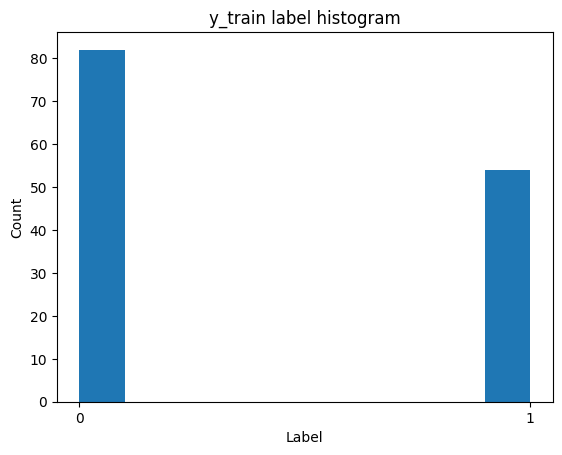

In [7]:
#It is also often helpful to know the percentage of your data that is in the positive and negative class
plt.hist(y_train.astype(int))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('y_train label histogram')
plt.xticks(range(2),labels=['0','1'])
plt.show()

## Define the Model

In [8]:
#Save file for the model and state_dictionary for in-progress training
MODEL_SAVE_FILE = "demo_model.pt"
MODEL_STATE_DICT = "demo_sd.pt"

#Number of networks you would like to learn
N_COMPONENTS = 20 # 20

#The shape of the data used for the encoder and decoder
DIM_IN = X_train.shape[1]

#Constrains the supervised network to a certain correlation. In the case of multiple supervised networks
#Input a list of network constraints such as ['Positive','Negative']. None is also acceptable if there is
#no preference for learned correlation.
NETWORK_CONSTRAINT = "Positive"

#Device that should be used (cpu or cuda:#). "auto" detects whether a gpu is present and selects it if
#available. Auto is not recommended for multiple GPU systems. 
DEVICE = "auto"

#The number of intercepts the model should learn for the logistic regression classifier
N_INTERCEPTS = y_intercept_mask.shape[1]

#Optimization algorithm used. AdamW tends to get better predictive performance whereas SGD helps with
#providing a smooth interpretation.
OPTIMIZER = "AdamW"

#only relevant if the optimizer is SGD. Helps encourage a smoother supervised network
MOMENTUM = 0.9

#The number of supervised networks you would like to train. In the case of more than 1, you must input
#y_train as a list of y vectors for each task you would like to supervise
N_SUP_NETWORKS = 1

#What type of reconstruction loss that will be used. MSE is what was used on previous cpne publications
#however, it can be sensitive to outliers. "IS" or itakura-saito divergence loss is scale invariant and
#can result in better results, but can be sensitive if the reconstruction values are close to 0.
RECON_LOSS = "MSE"

#Weighs the importance of reconstruction. Raise if reconstruction is poor.
SUP_RECON_WEIGHT = 1

#Weighs the importance of supervision. Lower if reconstruction is poor.
SUP_WEIGHT = 1

#Identifies whether we would like to use a neural network encoder or a linear encoder.
DEEP_ENC = True

#The breadth of the neural network encoder
H = 256

#This determines what type of supervised reconstruction loss is used. Residual is the default and is less
#strict than "All", however it can be prone to more sparse supervised networks. "All" can be too strict
#and result in supervised networks that try to represent all of the features rather than just those 
#relevant to the task of interest
SUP_RECON = "Residual"

#used with the residual supervised recon loss. Higher values discourage sparse supervised networks, but may result
#in poorer predictive performance.
SUP_SMOOTHNESS_WEIGHT = 1


#Feature groups provides the indices for each of the features used in the model. The model uses these
#indices to weigh the importance of reconstructing each feature. This means that the power features will
#still be important to the reconstruction, even though they only make up a small fraction of the features
running_idx = 0
feature_groups = []
for idx,feature in enumerate(X_FEATURE_LIST):
    f_begin = running_idx
    f_end = f_begin + train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end

FEATURE_GROUPS = feature_groups

#The weighting per group is calculated automatically if using None which will scale based on number of features. However,
#custom weighting may be chosen by hand. This vector should be the same length as X_FEATURE_LIST with a weight for each of
#the features
GROUP_WEIGHTS = None

In [9]:
#Define the model

#----------------------------------------------------------
# W A R N I N G
#
# The hyperparameters here and above are meant only to demonstrate usage for the model 
# and are in no way the recommended defaults
# for training your model.
#----------------------------------------------------------

model = dCSFA_NMF(n_components=N_COMPONENTS, #Number of learned networks
                dim_in=DIM_IN, #Number of features in X
                n_sup_networks=N_SUP_NETWORKS, #Number of networks to be supervised
                optim_name=OPTIMIZER, #What type of optimizer you would like to use {SGD,Adam,AdamW}
                recon_loss=RECON_LOSS, #What type of reconstruction loss to use {MSE,IS}
                sup_recon_weight=SUP_RECON_WEIGHT, #Importance of the supervised network reconstruction
                sup_weight=SUP_WEIGHT, #Importance of the supervision weight
                n_intercepts=N_INTERCEPTS, #Number of random intercepts (often grouped by mouse, experiment, etc.)
                useDeepEnc=DEEP_ENC, #Whether or not you would like to use the deep neural network encoder
                h=H, #The breadth of the neural network encoder
                sup_recon_type=SUP_RECON, #What type of supervised reconstruction loss you would like to use {Residual,All}
                feature_groups=FEATURE_GROUPS, #Breakpoints for each type of feature i.e. power, coh, granger. Used for equivalent feature weighting
                group_weights=GROUP_WEIGHTS, #Weights for each of the groups
                fixed_corr=NETWORK_CONSTRAINT, #Correlation constraints for the supervised networks
                momentum=MOMENTUM, #Momentum value for SGD with momentum - default is 0.9
                sup_smoothness_weight=SUP_SMOOTHNESS_WEIGHT #Parameter to encourage more smooth supervised networks if using the residual reconstruction
                )

## Fit the Model

In [10]:
#Fit or Load the model
LOAD = False

if LOAD:
    #Load the model onto the cpu
    model = torch.load(MODEL_SAVE_FILE,map_location='cpu')
    model.device='cpu'
else:
    #----------------------------------------------------------
    # W A R N I N G
    #
    # The hyperparameters here and above are meant only to demonstrate usage for the model and are in no way the recommended defaults
    # for training your model.
    #
    #
    # Also, please note that the recon loss reported during training is not the same as the MSE. This is reporting the weighted reconstruction
    # of the features. Also, AUCs are by-window so you should not expect them to match the by mouse auc that we collect later.
    #----------------------------------------------------------
    model.fit(X_train,
            y_train,
            y_sample_groups=y_sampling_train, 
            y_pred_weights=None,# Weights for the importance of each window for prediction. 
                                # If `None` then all windows are weighted equally, 
                                # see multiple network demo for usage
            intercept_mask=y_intercept_mask,
            task_mask=None, #Allows for masking which windows you would like to use with supervision
                            #See multiple network demo for usage
            n_epochs=1000, #Training time (1000)
            n_pre_epochs=100, #Pre-training time
            nmf_max_iter=500, #Maximum iterations for fitting unsupervised NMF for pretraining
            batch_size=128, #Batch size for gradient descent
            lr=1e-3, #Learning rate for gradient descent
            pretrain=True, #Indicates whether you would like to pretrain the model
            verbose=True, #Indicates you would like progress printouts during training
            X_val=X_val, #Validation data for early stopping (save the model with the best validation performance)
            y_val=y_val, #Validation labels for early stopping
            y_pred_weights_val=None, #same as above.
            task_mask_val=None, #Allows for masking which windows you would like to use with supervision
                                #See multiple network demo for usage
            best_model_name = MODEL_STATE_DICT #saved state of the model during training so best model can be reloaded
            )

    #Save the model
    torch.save(model,MODEL_SAVE_FILE)

Pretraining....
Pretraining NMF...
/shared-libs/python3.11/py/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
Identifying predictive components for network 0
100%|██████████| 20/20 [00:00<00:00, 171.28it/s]Selecting network: 13 with auc 0.5965447154471545 for sup net 0 using constraint positive correlation

Pretrain Epoch: 99, Recon Loss: 16.41: 100%|██████████| 100/100 [00:06<00:00, 15.56it/s]
Pretraining Complete
Beginning Training
Epoch: 999, Best Epoch: 998 Best Val Recon: 0.4986293315887451, Best Val by Window ROC-AUC: [0.4967948717948718] loss: 2.4892536401748657, recon: 0.08638446778059006, pred by Window roc-auc: [0.5941734417344172]: 100%|██████████| 1000/1000 [02:24<00:00,  6.91it/s]
Loading best model...
Done!


## Evaluate Model Training and Performance

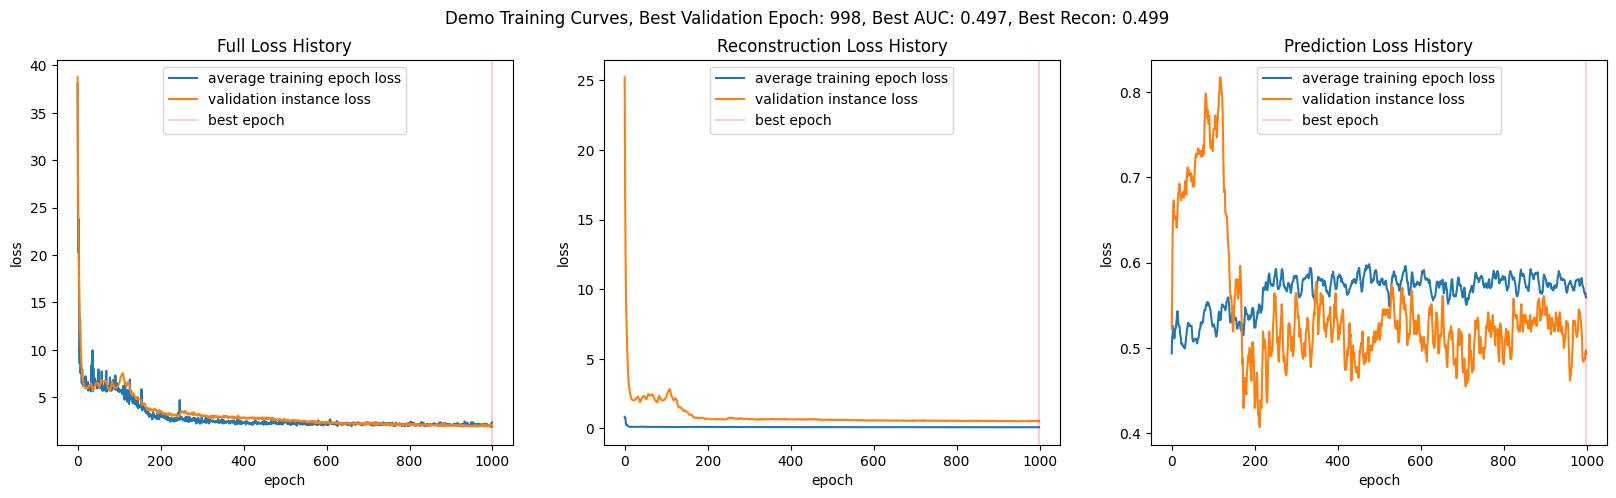

In [11]:
#The training losses are the sum losses over each training epoch. To make them comparable we get the average iteration loss for each epoch by dividing the
#training loss by a batch average factor which is approximately the number of training steps in an epoch.
BATCH_AVERAGE_FACTOR = X_train.shape[0]/128
BEST_EPOCH = model.best_epoch
BEST_AUC = model.best_val_auc[0]
BEST_VAL_RECON = model.best_val_recon.cpu().detach().numpy()
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(np.array(model.training_hist) / BATCH_AVERAGE_FACTOR,label='average training epoch loss')
plt.plot(model.val_loss_hist,label='validation instance loss')
plt.axvline(BEST_EPOCH,color='red',alpha=0.2,label='best epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Full Loss History')
plt.legend()


plt.subplot(1,3,2)
#val_recon_hist = [value.cpu().detach().numpy() for value in model.val_recon_loss_hist]
plt.plot(np.array(model.recon_hist) / BATCH_AVERAGE_FACTOR,label='average training epoch loss')
plt.plot(model.val_recon_loss_hist,label='validation instance loss')
plt.axvline(BEST_EPOCH,color='red',alpha=0.2,label='best epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Reconstruction Loss History')
plt.legend()


plt.subplot(1,3,3)
plt.plot(np.array(model.pred_hist) / BATCH_AVERAGE_FACTOR,label='average training epoch loss')
plt.plot(model.val_pred_loss_hist,label='validation instance loss')
plt.axvline(BEST_EPOCH,color='red',alpha=0.2,label='best epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Prediction Loss History')
plt.legend()

plt.suptitle("Demo Training Curves, Best Validation Epoch: {}, Best AUC: {:.3}, Best Recon: {:.3}".format(BEST_EPOCH,BEST_AUC,BEST_VAL_RECON))
plt.show()

## Evaluating Reconstruction Contribution of the Supervised Network

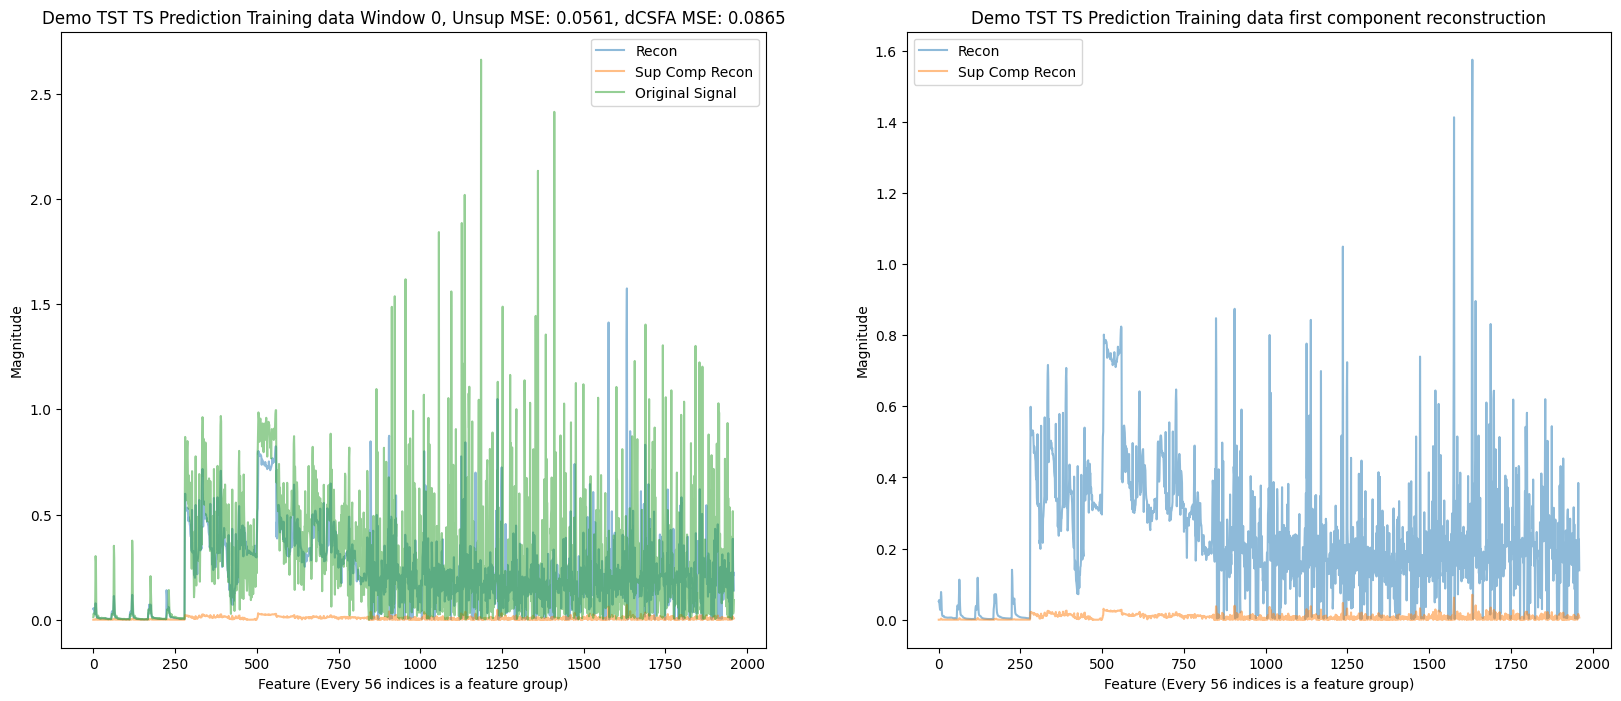

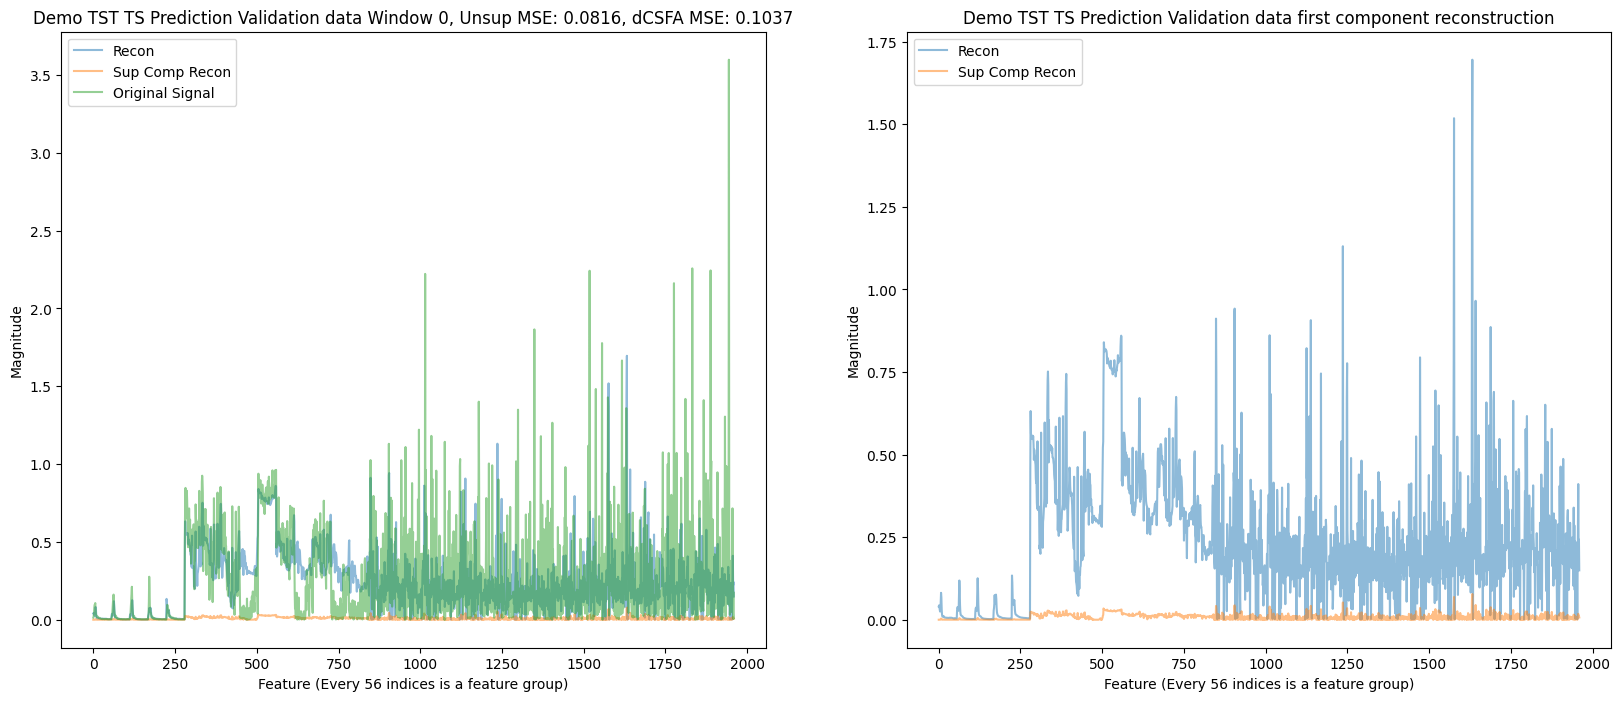

In [12]:
# These plots show the first component reconstructions and complete reconstructions for a single window. 
# The MSE for all windows is shown in the title.
umc_dt.make_recon_plots(model,X_train,0,task="Demo TST TS Prediction Training",saveFile="Demo_train_recon_plot.png")
umc_dt.make_recon_plots(model,X_val,0,task="Demo TST TS Prediction Validation",saveFile="Demo_val_recon_plot.png")

In [13]:
# It is often helpful to compare the MSE to the Variance of the data to infer how much true trend is caputered. 
# If the ratio is greater than 1 that is very bad.
val_mse = model.get_mse_score(X_val)
train_mse = model.get_mse_score(X_train)

var_train = np.std(X_train)**2
var_val = np.std(X_val)**2
print("Training MSE: {:.2}, Training Var: {:.2}, Ratio: {:.2}".format(train_mse,var_train,train_mse/var_train))
print("Validation MSE: {:.2}, Validation Var: {:.2}, Ratio: {:.2}".format(val_mse,var_val,val_mse/var_val))

Training MSE: 0.087, Training Var: 0.11, Ratio: 0.79
Validation MSE: 0.1, Validation Var: 0.1, Ratio: 1.0


(20, 280) (20, 560) (20, 1120)


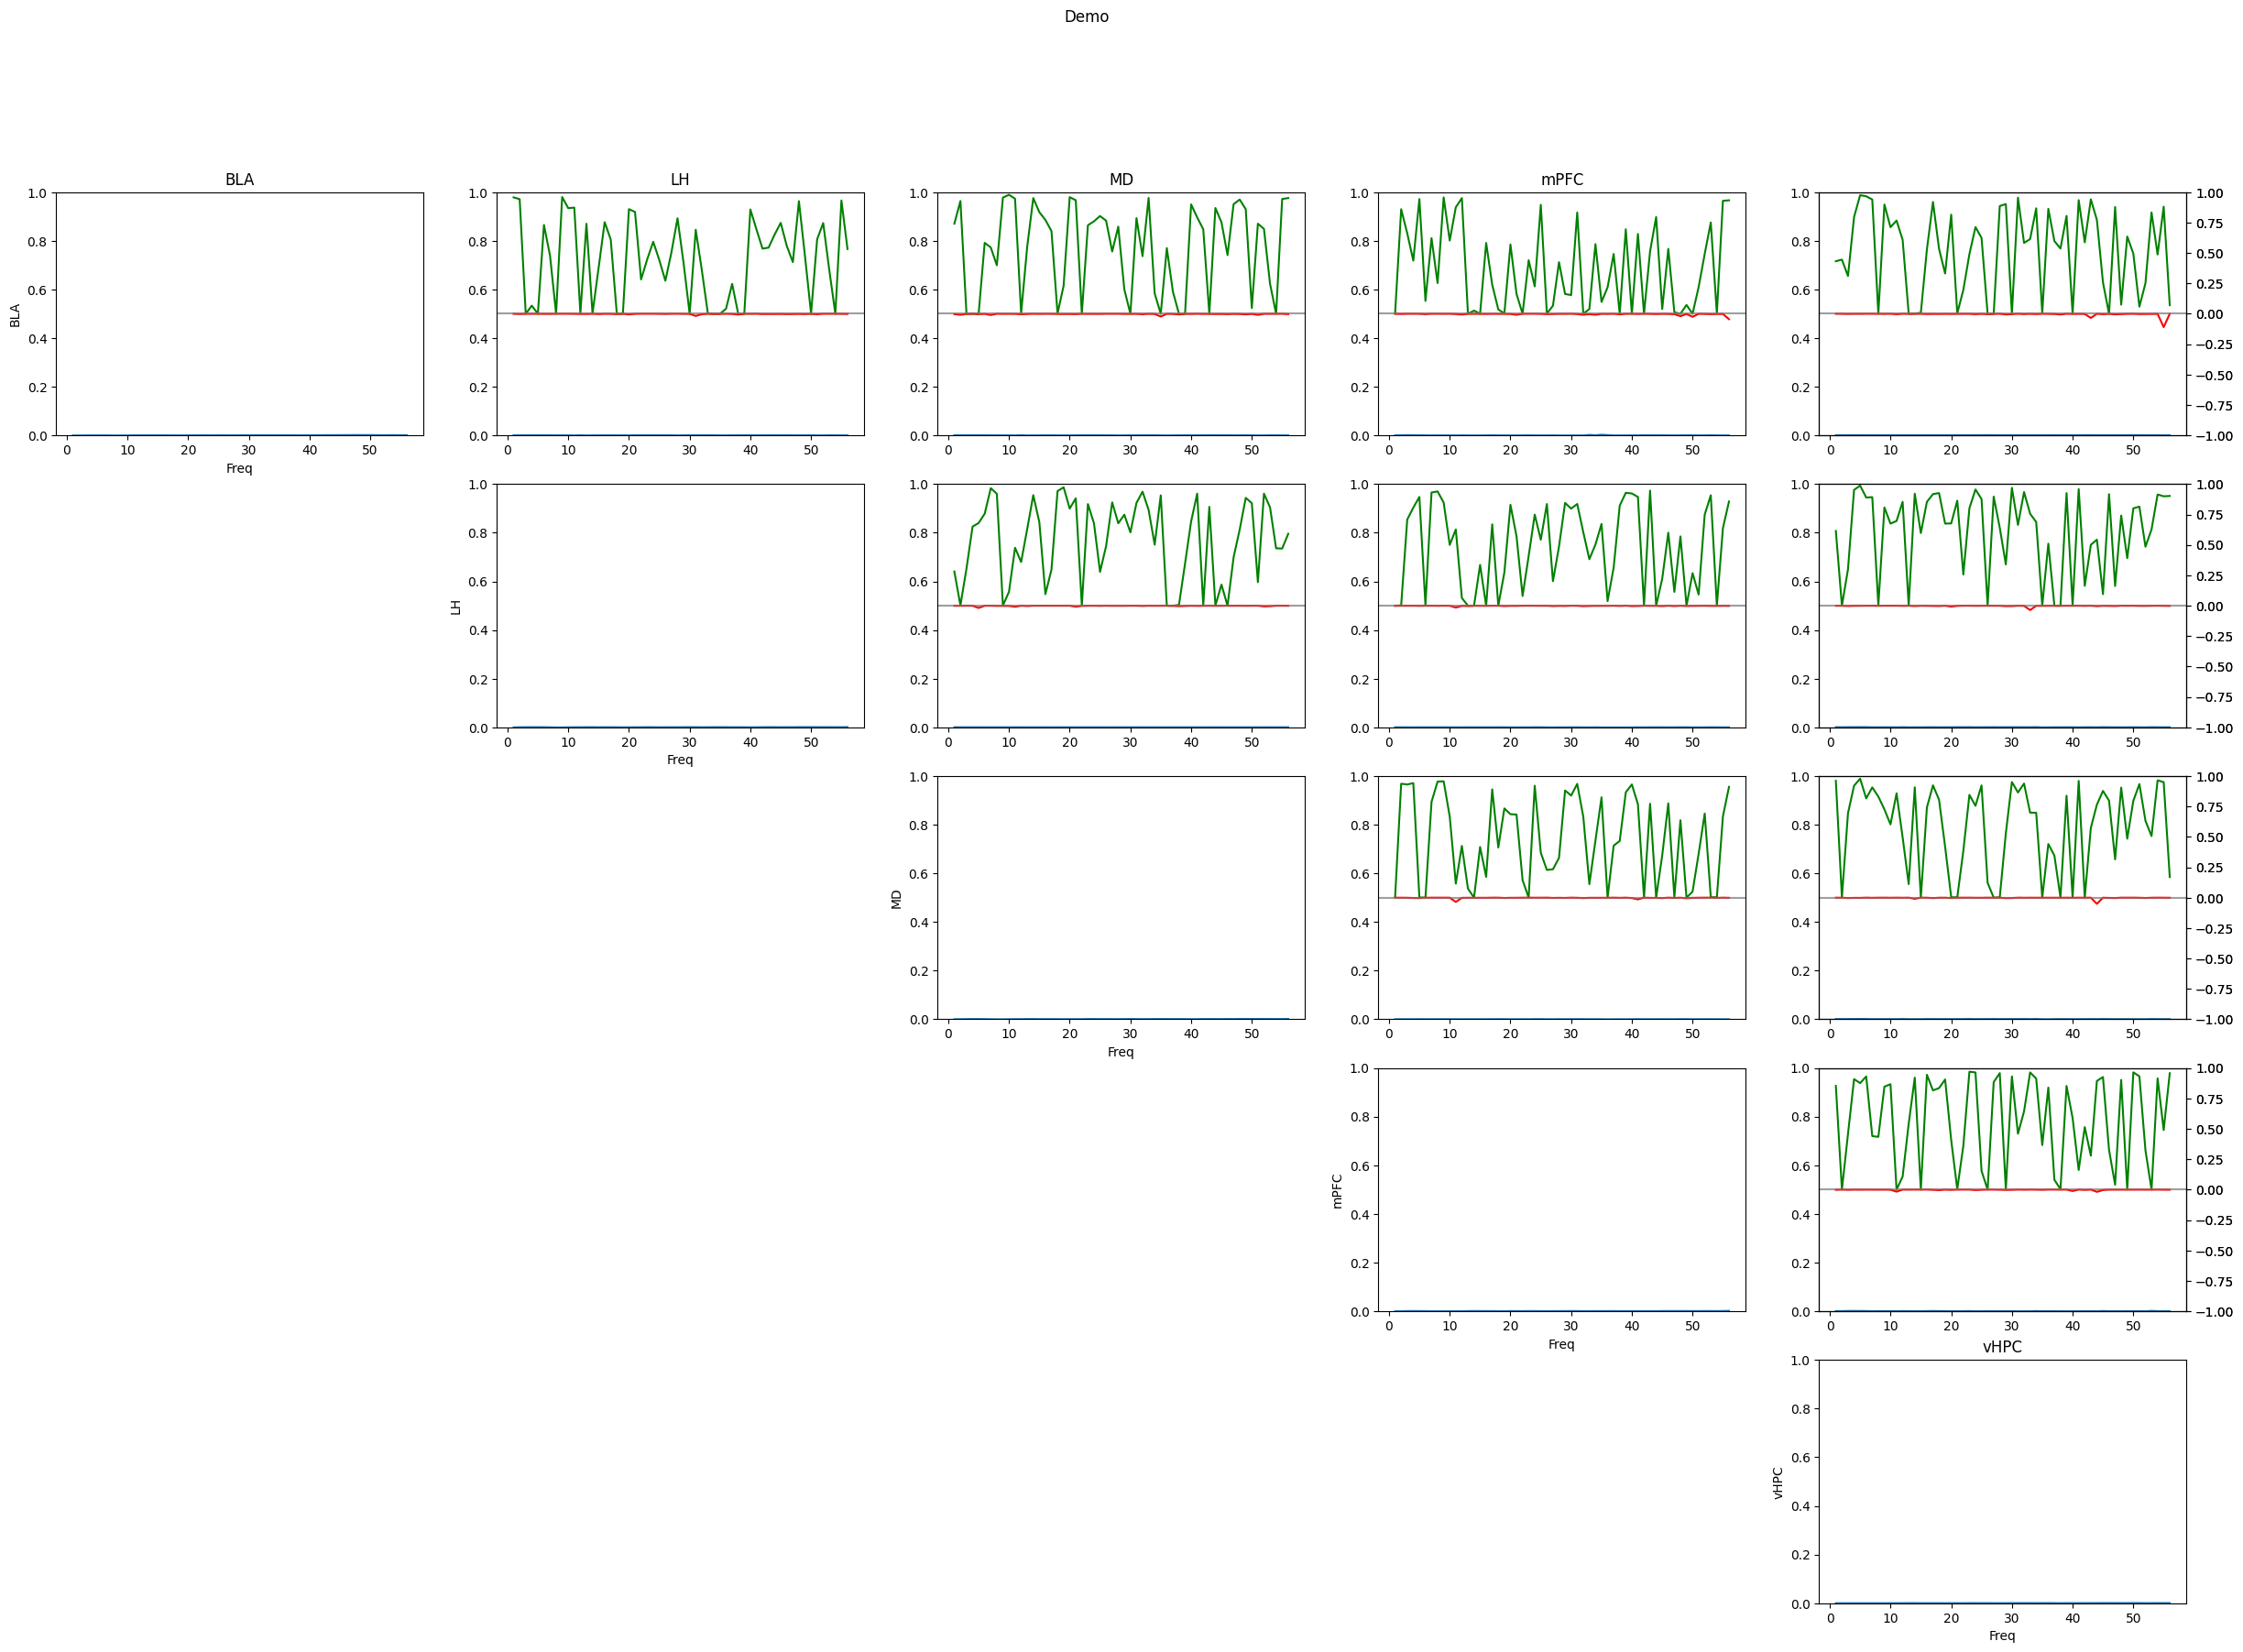

In [22]:
# We also want to evaluate how much our supervised network contributes to the reconstruction 
# of each feature. This allows us to gauge the influence
# our network has on overall brain activity. Green and Red indicate directionality. 
# Green is directionality from the row to the column and red
# is the directionality from the column area to the row area. 
# Red directionality is flipped for visibility and is marked using the far right axis
# of all plots that ranges from -1 to 1. 
# -1 indicates 100% contribution for red and 1 indicats 100% contribution for green. 
# Shapes of the power coherence and granger network contributions are 
# printed out before plotting as a debugging tool.

# Returns a K x M matrix where K is the number of networks learned and M is the number of features. 
# Each entry shows the kth networks percent
# contribution for reconstruction feature m. 
# If you sum this matrix along K, you should end up with a vector of approximately 1's.
perc_contribution = umc_dt.getReconContribution(X_val,N_COMPONENTS,model)

network_num = 1

if not DS_FEATURES:
    #Generate the plot
    umc_dt.makeUpperTriangularPlot_pow_coh_gc(perc_contribution, #matrix retrieved above
                                                areas=train_dict['areas'], #all areas recorded
                                                psdFeatures=train_dict['powFeatures'], #powerfeatures
                                                cohFeatures=train_dict['cohFeatures'], #coherence features of format Area1-Area2 <Freq #>
                                                gcFeatures=train_dict['gcFeatures'], #gc features of format Area1->Area2 <Freq #>
                                                freq=56, #number of frequencies per feature
                                                net_idx=network_num, #which network you would like to generate a plot for. Supervised networks are typically 0
                                                saveFile='UT_demo.png', #saveFile name
                                                title="Demo", #Title for your plot
                                                figsize=(30,20), #size of the plot (width, height)
                                                silenceTicks=False #whether you would like to include the left y-axis labels and x-axis labels on every subplot
                                                )

else:
    umc_dt.makeUpperTriangularPlot_pow_ds(perc_contribution, #matrix retrieved above
                                                areas=train_dict['areas'], #all areas recorded
                                                psdFeatures=train_dict['powFeatures'], #powerfeatures
                                                dsFeatures=train_dict['dsFeatures'], #gc features of format Area1->Area2 <Freq #>
                                                freq=56, #number of frequencies per feature
                                                net_idx=network_num, #which network you would like to generate a plot for. Supervised networks are typically 0
                                                saveFile='UT_demo.png', #saveFile name
                                                title="Demo", #Title for your plot
                                                figsize=(30,20), #size of the plot (width, height)
                                                silenceTicks=False #whether you would like to include the left y-axis labels and x-axis labels on every subplot
                                                )

In [15]:
# get feature names list
pow_lst = ["pow_"+ item for item in train_dict['powFeatures'].tolist()]
coh_lst = ["coh_"+ item for item in train_dict['cohFeatures'].tolist()]
gc_lst = ["gc_"+ item for item in train_dict['gcFeatures'].tolist()]
fet_lst = pow_lst + coh_lst + gc_lst
fet_lst = [item.split(' ')[0] for item in fet_lst]
fet_lst = pd.Series(fet_lst).drop_duplicates().tolist()

# feature contribution dataframe_lst
electome_network_lst = []
for i in range(perc_contribution.shape[0]):
    temp_df = pd.DataFrame(perc_contribution[i,:].reshape(-1,56).T)
    temp_df.columns = fet_lst
    electome_network_lst.append(temp_df)

# save list to disk for further visualization
with open('electome_network_lst.pkl', 'wb') as f:
    pickle.dump(electome_network_lst, f)

## Evaluating Model Predictive Performance

In [16]:
# It is frequently of interest to evaluate the by mouse AUC. This is different than by window 
# as we calculate the AUC for
# each mouse and then take the average and standard error of all mice. 
# We support evaluating the AUC using both the ROC-AUC
# and Mann-Whitney-U methods. 
# These methods should produce identical results in the case of a positively constrained network.
# if the network is negatively correlated, then the deviation from .5 should be the same. 
# For example a negatively correlated
# network with a roc-auc of .9 should have a mw auc of .1.
y_pred_proba, s = model.predict_proba(X_train,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred_proba,y_train.squeeze(),train_dict['y_mouse'])
print("train by-mouse roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred_proba,y_train.squeeze(),train_dict['y_mouse'],s,True)
print("train by-mouse mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

y_pred_proba, s = model.predict_proba(X_val,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred_proba,y_val.squeeze(),val_dict['y_mouse'])
print("Val by-mouse roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred_proba,y_val.squeeze(),val_dict['y_mouse'],s,True)
print("Val by-mouse mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

train by-mouse roc auc mean: 0.65 +/- 0.10
train by-mouse mw auc mean: 0.65 +/- 0.10
Val by-mouse roc auc mean: 0.50 +/- nan
Val by-mouse mw auc mean: 0.50 +/- nan
/root/work/umc_data_tools.py:278: RuntimeWarning: invalid value encountered in scalar divide
  std = np.std(auc_list) / np.sqrt(len(auc_list)-1)
/root/work/umc_data_tools.py:274: RuntimeWarning: invalid value encountered in scalar divide
  std = np.std(auc_list) / np.sqrt(len(auc_list)-1)


In [17]:
model.skl_pretrain_aucs_

[0.5965447154471545]

In [18]:
model.best_val_auc

[0.4967948717948718]

## Projections

In [19]:
# These are features from the specified projection data file that you would like included in the csv. 
# They must be features
# that have an entry for each window
INCLUDED_FEATURES = ["y_mouse","y_task"]

# The file you would like to save to
PROJECTION_SAVE_FILE = "demo_val_projection.csv"

# Get the auc for each mouse. Typically we want the mann-whitney auc so 
# we can infer correlation with the task
y_pred_proba, s = model.predict(X_val,include_scores=True)
mw_auc_dict = umc_dt.lpne_auc(y_pred_proba,y_val.squeeze(),val_dict['y_mouse'],s,True)

# Make the projection. This also returns a pandas dataframe so you can check that the csv 
# has the information you need right here
#in the same python environment.
projection_df = umc_dt.make_projection_csv(VALIDATION_DATA_FILE, #Pickle file you'd like to use for projection
                                            model, #Learned dCSFA-NMF model
                                            X_FEATURE_LIST, #Features used to construct X
                                            INCLUDED_FEATURES, #Features you'd like included in the csv
                                            PROJECTION_SAVE_FILE, #Save file for the csv
                                            auc_dict=mw_auc_dict, #by mouse auc dictionary
                                            auc_type="mw", #What type of auc calculation is being used
                                            weights=X_FEATURE_WEIGHTS) #Weights for each feature for construction X

projection_df

,scores,y_mouse,y_task,auc,p_val
0,0.297671,1.2,win,0.496795,0.990073
1,0.363970,1.2,lose,0.496795,0.990073
2,0.317855,1.2,lose,0.496795,0.990073
3,0.227827,1.2,win,0.496795,0.990073
4,0.263902,1.2,lose,0.496795,0.990073
5,0.275881,1.2,lose,0.496795,0.990073
6,0.358856,1.2,lose,0.496795,0.990073
7,0.238118,1.2,lose,0.496795,0.990073
8,0.260464,1.2,lose,0.496795,0.990073
9,0.220015,1.2,lose,0.496795,0.990073


In [20]:
model

dCSFA_NMF(
  (recon_loss_f): MSELoss()
  (Encoder): Sequential(
    (0): Linear(in_features=1960, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=256, out_features=20, bias=True)
    (4): Softplus(beta=1, threshold=20)
  )
  (phi_list): ParameterList(  (0): Parameter containing: [torch.float32 of size 1])
  (beta_list): ParameterList(  (0): Parameter containing: [torch.float32 of size 2x1])
)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d14e702a-7f9c-48a2-8d79-c67c05798ffa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>